<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_06_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Regular Dropout

In [2]:
# Define a dropout instance and create some data
# define the probability
prob = 0.5 # default

dropout = nn.Dropout(p=prob)
dropout

Dropout(p=0.5, inplace=False)

In [3]:
# Lets see what dropout returns
x = torch.ones(10)

y = dropout(x)
print(x)
print()
print(y) # y/(1-p), SCALED UP
print()
print(torch.mean(y))
# Independent probabilities

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

tensor([2., 0., 0., 2., 0., 0., 0., 0., 0., 0.])

tensor(0.4000)


In [4]:
# dropout is turned off when evaluating the model
dropout.eval()
# All lines within its identation will have dropout mode off
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [5]:
# Another way to use dropout is to use F.dropout()
dropout.eval()
y = F.dropout(x) # no need to specify instance
print(y)
print()
print(torch.mean(y))

tensor([2., 0., 0., 2., 0., 2., 2., 2., 2., 2.])

tensor(1.4000)


In [6]:
# We can manually switch it off with F
dropout.eval()
y = F.dropout(x, training=False)
print(y)
print()
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

tensor(1.)


In [7]:
# When a model is switched to eval mode it stays in it until it is switched back to training mode
dropout.train()
y = dropout(x)
print(y)
print()

dropout.eval()
y = dropout(x)
print(y)
print()

# dropout.train()
y = dropout(x) # will still be in eval unless dropout.train() is activated
print(y)

tensor([2., 0., 0., 2., 0., 0., 0., 2., 0., 0.])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


## Drop-Out Regularization

In [8]:
# Load all the additional libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [9]:
# The data is not linearly separable and DL is not necessary, but here we do it for practical purposes
nPerClust = 200

# define the angles
th = np.linspace(0, 4*np.pi, nPerClust)

# define the radii
r1 = 10
r2 = 15

# generate the data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3,
      r1*np.sin(th) + np.random.randn(nPerClust)]

b = [r2*np.cos(th) + np.random.randn(nPerClust),
     r2*np.sin(th) + np.random.randn(nPerClust)*3]

# Define the true labels
labels_np = np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1))))

[print(len(i)) for i in a]
print()
[print(len(i)) for i in b]
print()
print(labels_np.shape)

200
200

200
200

(400, 1)


In [10]:
# Concatenate into a single matrix
data_np = np.hstack((a,b)).T

# Convert to Tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

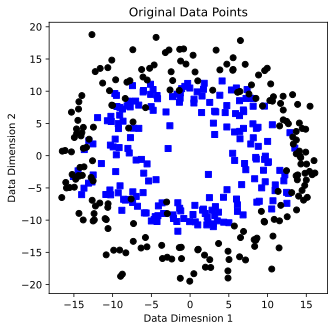

In [11]:
# Plot the whole thing
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], "bs")
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], "ko")
plt.title("Original Data Points")
plt.xlabel("Data Dimesnion 1")
plt.ylabel("Data Dimension 2")
plt.show()

In [12]:
# Separate the data into data loaders
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# Convert them to pytpruch datasets, they are a;ready tensors
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Convert them to dataloader objects
batchsize=16 # int(train_data.tensors[0].shape[0]/4) for soft coding
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [13]:
# Create the model class
class theModelClass(nn.Module):
    def __init__(self,dropoutRate):
        super().__init__()

        # Layers
        self.input  = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128,1)

        # Parameters
        self.dr = dropoutRate

    # Define forward pass
    def forward(self,x):

        # Pass the data through the input layer
        x = F.relu(self.input(x))

        # Dropout after input layer
        x = F.dropout(x, p=self.dr, training=self.training) # No need to set to true or false every time. This way it is set to true when model is on train mode and off otherwise

        # Pass the data through the hidden layer
        x = F.relu(self.hidden(x))

        # Dropout after hidden layer
        x = F.dropout(x, p=self.dr, training=self.training)

        # Outout layer
        x = self.output(x) # No dropout here

        return x

In [15]:
# Test the model
tmpnet = theModelClass(0.25)

# Run some random data through. Untrained model, just checking whether it runs
tmpdata = torch.randn((10,2))
yhat = tmpnet(tmpdata)
yhat

tensor([[-0.2187],
        [-0.1992],
        [-0.0642],
        [-0.1896],
        [ 0.1014],
        [-0.2076],
        [-0.1466],
        [-0.1086],
        [-0.0841],
        [-0.3372]], grad_fn=<AddmmBackward0>)

## Create and Train the Network

In [16]:
def createANewModel(dropoutrate):

    # Grab an instance of the model class
    ANNQC = theModelClass(dropoutrate)

    # define the loss function
    lossfun = nn.BCEWithLogitsLoss()

    # Optimizer
    optimizer = torch.optim.SGD(ANNQC.parameters(), lr = 0.002)

    return ANNQC, lossfun, optimizer

In [19]:
# Train the model

# Define the number of epochs
numepochs = 1000

def trainTheModel(ANNQC, lossfun, optimizer):

    # Initialize accuracies
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Switch training mode on
        ANNQC.train()

        # Loop over training data batches
        batchAcc = []
        for X,y in train_loader: # Minibatch

            # Forward pass and loss
            yHat = ANNQC(X)
            loss = lossfun(yHat,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute batch accuracy
            batchAcc.append(100*torch.mean(((yHat>0.5)==y).float()).item())
        # End of batch loop

        # Now that we finished training throuh the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # Test Accuracy
        # Switch training off
        ANNQC.eval()
        # Extract data from test loader
        X,y = next(iter(test_loader))
        yHat = ANNQC(X)
        testAcc.append(100*torch.mean(((yHat >0.5)==y).float()).item())

    # Function putput
    return trainAcc, testAcc

In [20]:
# Time to test the model
dropoutrate = 0.0
ANNQC, lossfun, optimizer = createANewModel(dropoutrate)

# Train the model
trainAcc, testAcc = trainTheModel(ANNQC, lossfun, optimizer)

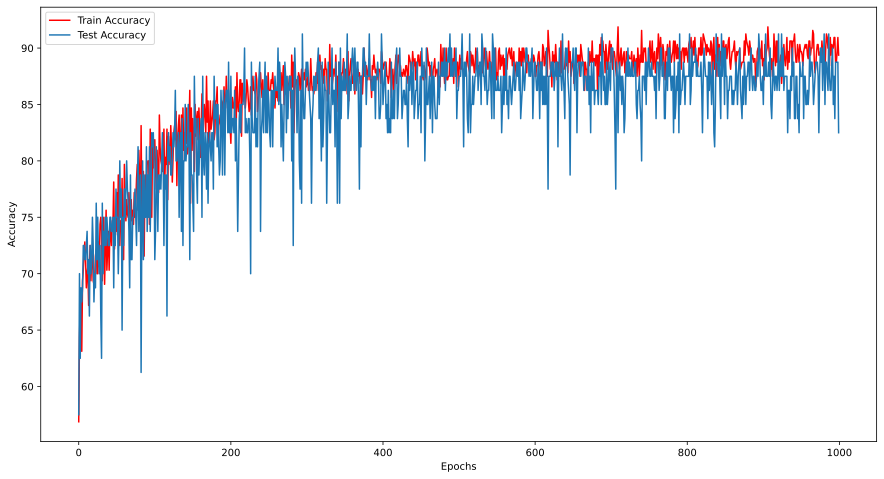

In [28]:
# Quick Visualization
fig = plt.figure(figsize=(15,8))
plt.plot(trainAcc, "r", label = "Train Accuracy")
plt.plot(testAcc, label = "Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
# The jittery nature of the plot is related to batch size

In [27]:
# Create a 1D Smoothing filter
def smooth(x,k=5):
    return np.convolve(x, np.ones(k)/k, mode="same")

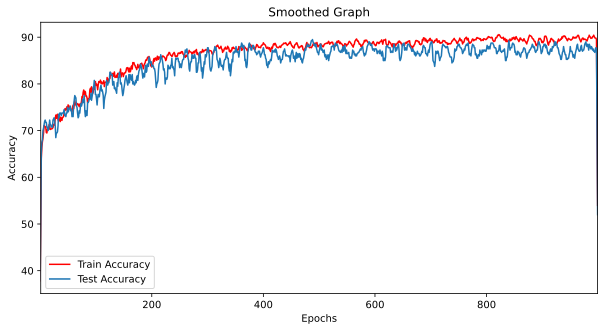

In [32]:
fig = plt.figure(figsize=(10,5))
plt.plot(smooth(trainAcc), "r", label = "Train Accuracy")
plt.plot(smooth(testAcc), label = "Test Accuracy")
plt.xlim([1,999])
plt.title("Smoothed Graph")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Run Experiment with Varying Dropout

In [37]:
dropoutRates = np.arange(10)/10

# empty array to store results
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

    # Create and train the model
    ANNQC, lossfun, optimizer = createANewModel(dropoutRates[di])
    trainAcc, testAcc = trainTheModel(ANNQC, lossfun, optimizer)

    # Store accuracies from the last 100 epochs because there is not much change
    results[di,0] = np.mean(trainAcc[-100:])
    results[di,1] = np.mean(testAcc[-100:])

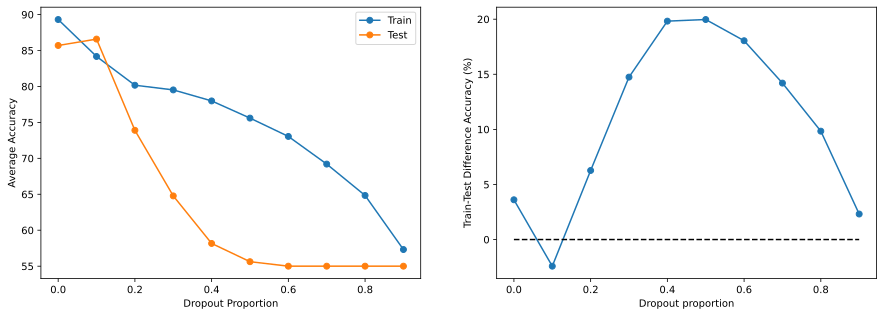

In [38]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(dropoutRates, results, "o-")
ax[0].set_xlabel("Dropout Proportion")
ax[0].set_ylabel("Average Accuracy")
ax[0].legend(["Train", "Test"])

ax[1].plot(dropoutRates, -np.diff(results, axis=1), "o-")
ax[1].plot([0,0.9], [0,0], "k--")
ax[1].set_xlabel("Dropout proportion")
ax[1].set_ylabel("Train-Test Difference Accuracy (%)")

plt.show()

# Increasing dropout rate makes performance worse